In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - "04_11_24_WBC_UniverSeg_LocalSmoothing"
    
calibration:
    metric_cfg_file: "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference/Calibration_Metrics.yaml"

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: True 

<IPython.core.display.Javascript object>

In [3]:
from ese.experiment.analysis.analyze_inf import load_cal_inference_stats

image_info_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/libraries/pylot/pandas/register.py:47: UserWarning: registration of accessor <class 'pylot.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overridi

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 18000 -> 18000 rows.
Finished loading inference stats.
Log amounts: log.root                                                                                                             log_set                                              
/storage/vbutoi/scratch/ESE/inference/04_11_24_WBC_UniverSeg_LocalSmoothing/WBC_Ensemble_ContextualHistogramBinning  20240411_165911-SMWA-eb5c9e0d1ba3f5c13bef69afbd0a02cf    1300
                                                                                                                     20240411_165915-D2KD-0b69a4f04d529a9e82af9e7496da6287    1300
                                                                                                                     20240411_165919-QJGC-90357ccb8f4136de7208031599cee0b7    1300
                                                                                                                     20240411_170615-NSSF-4a1e3a634f4485e

In [4]:
image_info_df['calibrator'].unique()

array(['ContextualHistogramBinning (norm,None)', 'Uncalibrated'],
      dtype=object)

In [15]:
# Sort the image_info_df by method name, so everything appears nicely
image_info_df = image_info_df.sort_values(by=['method_name', 'calibrator'])
# Make sure that the model_class 'Uncalibrated' is first
image_info_df['calibrator'] = image_info_df['calibrator'].astype('category')
image_info_df['calibrator'] = image_info_df['calibrator'].cat.reorder_categories([
    'Uncalibrated',
    'ContextualHistogramBinning (norm,None)'
])

# Make sure that the model_class 'Uncalibrated' is first
image_info_df['conf_pool_width'] = image_info_df['conf_pool_width'].astype('category')
image_info_df['conf_pool_width'] = image_info_df['conf_pool_width'].cat.reorder_categories([
    'None',
    1.0,
    3.0,
    5.0,
    7.0,
])

In [6]:
# image_info_df = image_info_df[image_info_df['calibrator'] == 'Uncalibrated']

In [7]:
image_info_df.keys()

Index(['support_idx', 'data_id', 'split', 'slice_idx', 'image_metric',
       'metric_score', 'groupavg_image_metric', 'groupavg_metric_score',
       'num_lab_0_pixels', 'num_lab_1_pixels', 'ECE', 'Edge-ECE', 'CW-ECE',
       'ECW-ECE', 'Uniform-CW-ECE', 'Uniform-ECW-ECE', 'log_set',
       'calibrator._class', 'calibrator._name', 'calibrator.conf_pool_width',
       'calibrator.normalize', 'data.input_type', 'data.label', 'data.preload',
       'data.resolution', 'data.slicing', 'data.splits', 'data.support_size',
       'data.task', 'dataloader.batch_size', 'dataloader.num_workers',
       'dataloader.pin_memory', 'dataset._class', 'dataset.label',
       'dataset.min_label_density', 'dataset.preload', 'dataset.resolution',
       'dataset.return_data_id', 'dataset.samples_per_epoch',
       'dataset.slicing', 'dataset.support_size', 'dataset.task',
       'dataset.version', 'ensemble.combine_fn', 'ensemble.combine_quantity',
       'ensemble.normalize', 'ensemble.num_members', 'exp

In [8]:
image_info_df['image_metric'].unique()

array(['Dice', 'HD95', 'BoundaryIOU', 'Pixel-Ambiguity',
       'Soft-Region-Ambiguity', 'Hard-Region-Ambiguity', 'Image_ECE',
       'Image_Edge-ECE', 'Image_CW-ECE', 'Image_ECW-ECE',
       'Image_Uniform-CW-ECE', 'Image_Uniform-ECW-ECE', 'Dice Loss'],
      dtype=object)

In [9]:
# Sort the df by the data_id
image_info_df = image_info_df.sort_values(by=['data_id'])

Text(0.5, 1.0, 'WBC Dice Loss vs. Support-Set Size')

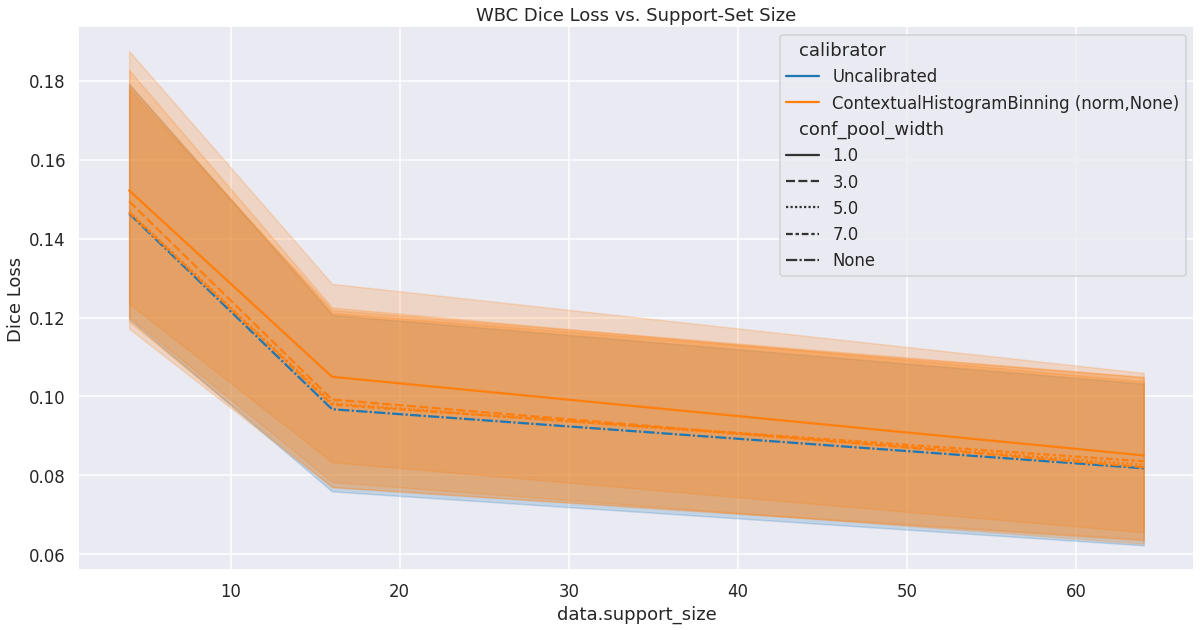

In [10]:
dice_info_df = image_info_df[image_info_df['image_metric'] == 'Dice Loss']

plt.figure(figsize=(20, 10))
sns.lineplot(
    x='data.support_size', 
    y='metric_score', 
    hue='calibrator',
    style='conf_pool_width',
    data=dice_info_df,
)
# Set the y label to be Image ECE
plt.ylabel('Dice Loss')
plt.title('WBC Dice Loss vs. Support-Set Size')

In [11]:
dice_info_df

,support_idx,data_id,split,slice_idx,image_metric,metric_score,groupavg_image_metric,groupavg_metric_score,num_lab_0_pixels,num_lab_1_pixels,...,combine_quantity,member_w_metric,member_temps,model_norm,ensemble_norm,metric_type,model_type,joint_data_slice_id,method_name,configuration
18460,0,003,val,None,Dice Loss,0.051809,GroupAvg_Dice,None,14740,1644,...,probs,None,None,None,False,quality,group,003_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18461,1,003,val,None,Dice Loss,0.052016,GroupAvg_Dice,None,14740,1644,...,probs,None,None,None,False,quality,group,003_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18462,2,003,val,None,Dice Loss,0.070473,GroupAvg_Dice,None,14740,1644,...,probs,None,None,None,False,quality,group,003_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18463,3,003,val,None,Dice Loss,0.228443,GroupAvg_Dice,None,14740,1644,...,probs,None,None,None,False,quality,group,003_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18464,4,003,val,None,Dice Loss,0.022961,GroupAvg_Dice,None,14740,1644,...,probs,None,None,None,False,quality,group,003_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18651,1,098,val,None,Dice Loss,0.043705,GroupAvg_Dice,None,14353,2031,...,probs,None,None,None,False,quality,group,098_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18650,0,098,val,None,Dice Loss,0.046501,GroupAvg_Dice,None,14353,2031,...,probs,None,None,None,False,quality,group,098_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18654,4,098,val,None,Dice Loss,0.045530,GroupAvg_Dice,None,14353,2031,...,probs,None,None,None,False,quality,group,098_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."
18653,3,098,val,None,Dice Loss,0.046501,GroupAvg_Dice,None,14353,2031,...,probs,None,None,None,False,quality,group,098_None,"Ensemble (mean, probs)","Ensemble (mean, probs)_ContextualHistogramBinn..."


Text(0.5, 1.0, 'WBC HD95 vs. Support-Set Size')

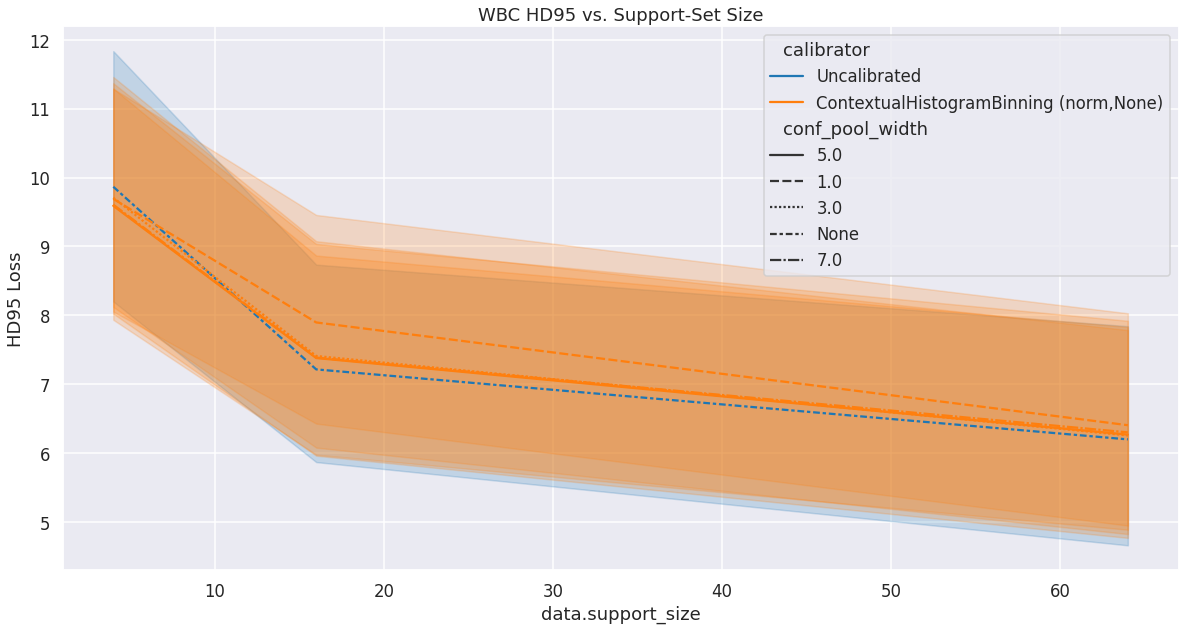

In [12]:
hd_info_df = image_info_df[image_info_df['image_metric'] == 'HD95']

plt.figure(figsize=(20, 10))
sns.lineplot(
    x='data.support_size', 
    y='metric_score', 
    hue='calibrator',
    style='conf_pool_width',
    data=hd_info_df,
)
# Set the y label to be Image ECE
plt.ylabel('HD95 Loss')
plt.title('WBC HD95 vs. Support-Set Size')

Text(0.5, 1.0, 'WBC Image ECE vs. Support-Set Size')

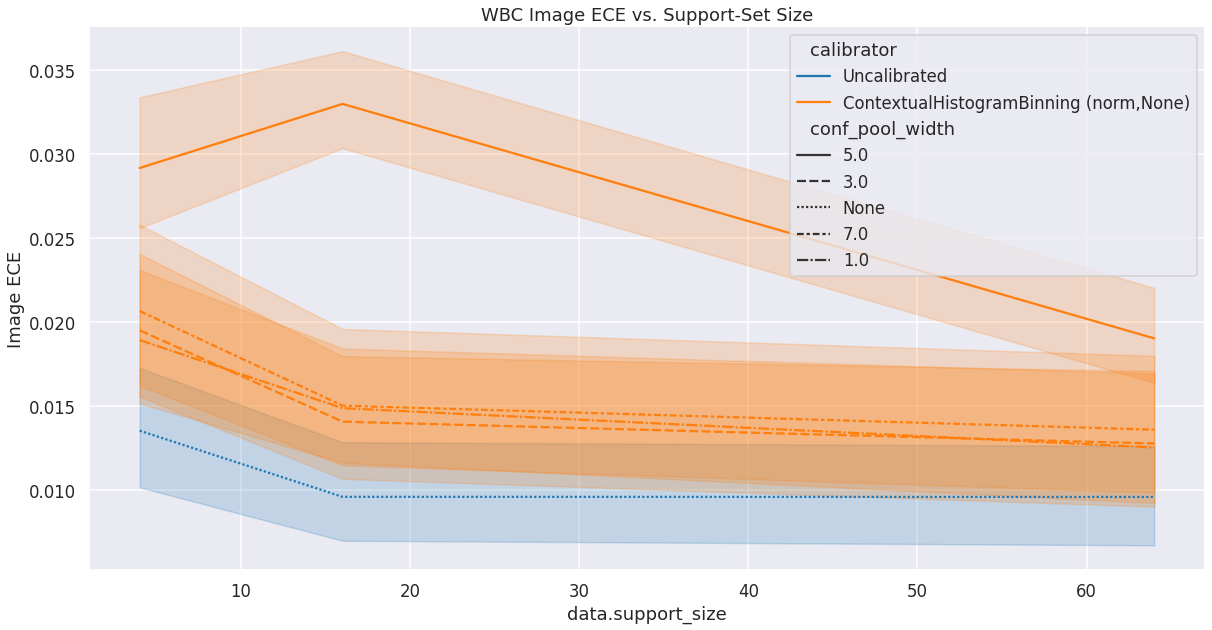

In [13]:
ece_info_df = image_info_df[image_info_df['image_metric'] == 'Image_ECE']

plt.figure(figsize=(20, 10))
sns.lineplot(
    x='data.support_size', 
    y='metric_score', 
    hue='calibrator',
    style='conf_pool_width',
    data=ece_info_df,
)
# Set the y label to be Image ECE
plt.ylabel('Image ECE')
plt.title('WBC Image ECE vs. Support-Set Size')